# Soft Actor Critic (SAC): Off-Policy Maximum Entropy Deep Reinforcement Learning with a Stochastic Actor

imports

In [1]:
import math
import random

import gymnasium as gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal


from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline


use cuda

In [2]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


Replay buffer

In [3]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)

Define an env wrapper to normalize the actions

In [4]:
class NormalizedActions(gym.ActionWrapper):
    def action(self, action):
        low  = self.action_space.low
        high = self.action_space.high
        
        action = low + (action + 1.0) * 0.5 * (high - low)
        action = np.clip(action, low, high)
        
        return action

    def reverse_action(self, action):
        low  = self.action_space.low
        high = self.action_space.high
        
        action = 2 * (action - low) / (high - low) - 1
        action = np.clip(action, low, high)
        
        return actions


plot utility

In [5]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()


## Networks design

In [6]:
class ValueNetwork(nn.Module):
    def __init__(self, state_dim, hidden_dim, init_w=3e-3):
        super(ValueNetwork, self).__init__()
        
        self.linear1 = nn.Linear(state_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x
        
        
class SoftQNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(SoftQNetwork, self).__init__()
        
        self.linear1 = nn.Linear(num_inputs + num_actions, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x
        
        
class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3, log_std_min=-20, log_std_max=2):
        super(PolicyNetwork, self).__init__()
        
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        
        self.mean_linear = nn.Linear(hidden_size, num_actions)
        self.mean_linear.weight.data.uniform_(-init_w, init_w)
        self.mean_linear.bias.data.uniform_(-init_w, init_w)
        
        self.log_std_linear = nn.Linear(hidden_size, num_actions)
        self.log_std_linear.weight.data.uniform_(-init_w, init_w)
        self.log_std_linear.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        
        mean    = self.mean_linear(x)
        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        
        return mean, log_std
    
    def evaluate(self, state, epsilon=1e-6):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        ##### TODO ####
        #z = ??
        #action=??
        #         
        normal = Normal(0, 1)
        z      = normal.sample()
        action = torch.tanh(mean+ std*z.to(device))
        log_prob = Normal(mean, std).log_prob(mean+ std*z.to(device)) - torch.log(1 - action.pow(2) + epsilon) #second term is an adjustment that compensates for the squeezing of the tanh transformation
        return action, log_prob, z, mean, log_std
        
    
    def get_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        mean, log_std = self.forward(state)
        std = log_std.exp()
        ### TODO ###
        #
        #action = sample from a gaussian with mean and std with the reparametrization trick
        #
        
        normal = Normal(0, 1)
        z      = normal.sample().to(device)
        action = torch.tanh(mean + std*z)
        
        action  = action.cpu().detach().numpy()
        return action[0]

    def get_action_greedy(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        mean, log_std = self.forward(state)
        action = torch.tanh(mean)
        action  = action.cpu().detach().numpy()
        return action[0]

Update the networks

In [7]:
def soft_q_update(batch_size,gamma=0.99,soft_tau=1e-2,):
    
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = torch.FloatTensor(state).to(device)
    next_state = torch.FloatTensor(next_state).to(device)
    action     = torch.FloatTensor(action).to(device)
    reward     = torch.FloatTensor(reward).unsqueeze(1).to(device)
    done       = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(device)
    
    predicted_q_value1 = soft_q_net1(state, action)
    predicted_q_value2 = soft_q_net2(state, action)
    predicted_value    = value_net(state)
    new_action, log_prob, epsilon, mean, log_std = policy_net.evaluate(state)

    # Training Value Function
    ########## TODO #######
    #
    # value_loss = ??
    #
    predicted_new_q_value = torch.min(soft_q_net1(state, new_action),soft_q_net2(state, new_action))
    target_value_func = predicted_new_q_value - log_prob
    value_loss = value_criterion(predicted_value, target_value_func.detach())
    #print("V Loss")
    #print(value_loss)
    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()

    # Training Q Function
    ######## TODO ######
    #
    #target_q_value = ??
    #
    target_value = target_value_net(next_state)
    target_q_value = reward + (1 - done) * gamma * target_value
    q_value_loss1 = soft_q_criterion1(predicted_q_value1, target_q_value.detach())
    q_value_loss2 = soft_q_criterion2(predicted_q_value2, target_q_value.detach())
    #print("Q Loss")
    #print(q_value_loss1)
    soft_q_optimizer1.zero_grad()
    q_value_loss1.backward()
    soft_q_optimizer1.step()
    soft_q_optimizer2.zero_grad()
    q_value_loss2.backward()
    soft_q_optimizer2.step()    
    
    # Training Policy Function
    ######## TODO #######
    #
    # policy loss = ??
    #
    policy_loss = (log_prob - predicted_new_q_value).mean()

    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()
    
    # Update the target Value function parameters
    for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
        ##### TODO ###
        # update target parameters using soft_tau
        #
        target_param.data.copy_(
            target_param.data * (1.0 - soft_tau) + param.data * soft_tau
        )

    return (q_value_loss1.item()+q_value_loss2.item())/2 + value_loss.item() + policy_loss.item()

## Test on pendulum

Define the env

In [16]:
env = NormalizedActions(gym.make("Pendulum-v1"))

action_dim = env.action_space.shape[0]
state_dim  = env.observation_space.shape[0]

print(action_dim)
print(state_dim)

1
3


Define networks, optimizer and replay buffer

In [17]:

hidden_dim = 256

value_net = ValueNetwork(state_dim, hidden_dim).to(device)
target_value_net = ValueNetwork(state_dim, hidden_dim).to(device)
value_net.train()
target_value_net.train()

soft_q_net1 = SoftQNetwork(state_dim, action_dim, hidden_dim).to(device)
soft_q_net2 = SoftQNetwork(state_dim, action_dim, hidden_dim).to(device)
policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim).to(device)
soft_q_net1.train()
soft_q_net2.train()
policy_net.train()

for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
    target_param.data.copy_(param.data)
    

value_criterion  = nn.MSELoss()
soft_q_criterion1 = nn.MSELoss()
soft_q_criterion2 = nn.MSELoss()
lr  = 3e-4

value_optimizer  = optim.Adam(value_net.parameters(), lr=lr)
soft_q_optimizer1 = optim.Adam(soft_q_net1.parameters(), lr=lr)
soft_q_optimizer2 = optim.Adam(soft_q_net2.parameters(), lr=lr)

policy_optimizer = optim.Adam(policy_net.parameters(), lr=lr)


replay_buffer_size = 1000000
replay_buffer = ReplayBuffer(replay_buffer_size)



Training

In [18]:
max_frames  = 60000
max_steps   = 500
frame_idx   = 0
episode = 0
rewards     = []
losses = []
batch_size  = 128
desired_rew = -160
window = 50

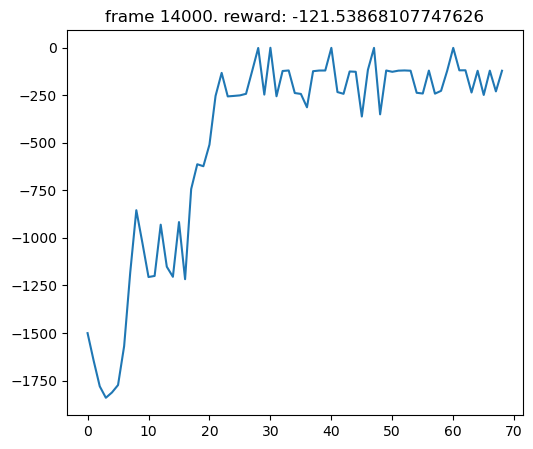

Episode 74 Mean Rewards -158.76  Episode reward = -120.43   mean loss = 128.52		

In [19]:
from statistics import mean

while frame_idx < max_frames:
    state, _ = env.reset()
    episode_reward = 0
    losses_ep = []
    for step in range(max_steps):
        
        ###### TODO ####
        #take the action with the policy net
        #
        #action = ??
        action = policy_net.get_action(state)
        next_state, reward, terminated, truncated, _= env.step(action)
        #if truncated: print("!!! truncated")
        done = terminated or truncated
        
        #### TODO ####
        #
        #put transition in the replay buffer
        #        
        replay_buffer.push(state, action, reward, next_state, terminated)
        if len(replay_buffer) > batch_size:
            loss = soft_q_update(batch_size)
            losses_ep.append(loss)
        
        state = next_state
        episode_reward += reward
        frame_idx += 1
        
        if frame_idx % 1000 == 0:
            plot(frame_idx, rewards)
        
        if done:
            break
    episode += 1

    rewards.append(episode_reward)
    losses.append(mean(losses_ep))
    mean_rewards = mean(rewards[-window:])
    mean_loss = mean(losses[-window:])
    print("\rEpisode {:d} Mean Rewards {:.2f}  Episode reward = {:.2f}   mean loss = {:.2f}\t\t".format(
                            episode, mean_rewards, episode_reward, mean_loss), end="")
    if mean_rewards >= desired_rew:
       break
    # if episode >= 25:
    #     break

Final test

In [20]:
from matplotlib import animation
import matplotlib.pyplot as plt

def save_frames_as_gif(frames, path='./', filename='SAC.gif'):

    #Mess with this to change frame size
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    anim.save(path + filename, writer='imagemagick', fps=60)

MovieWriter imagemagick unavailable; using Pillow instead.


Tot reward in one episode:  -121.41995209215398


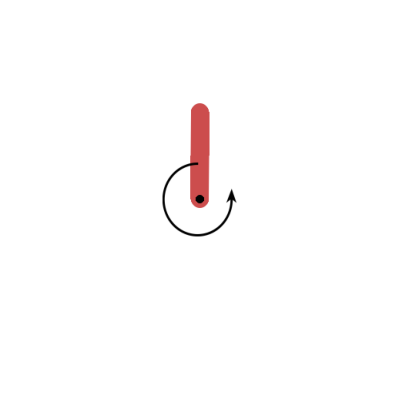

In [21]:
done = False
tot_rew = 0
env = NormalizedActions(gym.make("Pendulum-v1", render_mode='rgb_array'))

state, _ = env.reset()
frames_gif=[]
policy_net.eval()
for step in range(max_steps):
    frames_gif.append(env.render())
    action = policy_net.get_action(state)
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    tot_rew += reward
    if done:
        break
    state = next_state
save_frames_as_gif(frames_gif)
print("Tot reward in one episode: ", tot_rew)